<h1 align="center">EF Machine Learning Homework</h1>


# The Machine Learning Tasks

The task(s) is(are) to build a system to classify the Level of writing samples by english language learners, using a data set gathered from users. Each Level is comprised of multiple units. Learners progress in linear order from one Level to the next, although within a Level, they may jump around from one unit to another at will.  Typically one of the last units in a Level is the “written task”, in which the learners write freely on a given topic.

# Convert XML to Pandas DataFrame ( <a href="https://github.com/dipanjank/ml/blob/master/ef_homework/step_1_data_prep.ipynb">step_1_data_prep.ipynb</a>)

In this step, I converted the raw XML(https://www.dropbox.com/s/rizbq4co1hlfpft/EFWritingData.xml?dl=0) into a pandas DataFrame. Each row in DataFrame is a flat representation of one `<writing>` element, sub-elements and attributes. I excluded the article date in the conversion since I wasn't sure about using it in the classification step.
   

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd 
import numpy as np
import seaborn as sns

In [2]:
raw_input = pd.read_pickle('input.pkl')
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit
0,1,90,6,"After some time, the affection between them is...",41,Writing a movie plot,1
1,2,90,6,An e-ticket is a provement that you bought the...,42,Filling in an arrival card,2
2,3,86,6,From:xxx@1234.com To:Herman xxx@1234.com Date:...,43,Creating an office dress code,3
3,4,87,1,"Hi Anna ,How are you . My name's Jayla . My te...",1,Introducing yourself by email,1
4,5,95,1,"Dear Ms Thomas, There are thirty pens and fift...",2,Taking inventory in the office,2


# Analysis of MetaData

I first investigated the relationships between the metadata fields and the `level` attribute. The metadata fields excluding `date` are:

* article_id  
* grade         
* level         
* topic_id      
* topic_text    
* unit

Figure below shows the boxplot of `topic_id` for each distinct value of `level`.

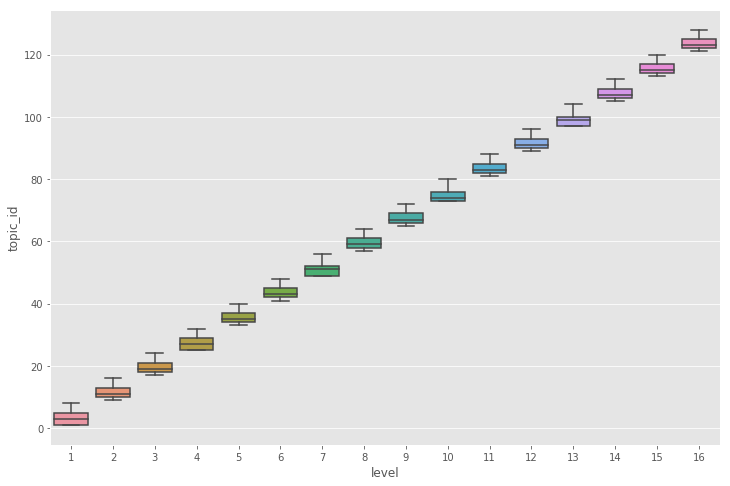

In [3]:
ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.boxplot(x='level', y='topic_id', data=raw_input)

Each level belongs to a mutually exclusive set of topic IDs. **We can deterministically figure out the level from the topic_id without using any Machine Learning.** However since this homework is for text classification, I chose to go ahead and build a text classifier without using the `topic_id` or the `topic_text` in the model.

Figure below shows the boxplots per level for the other two metadata features, `unit` and `grade`. 
Visually they didn't seem to be good predictors for `level`.

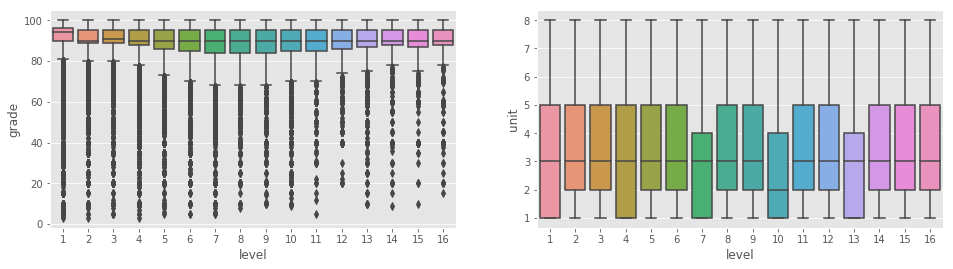

In [4]:
_, ax = plt.subplots(1, 2, figsize=(16, 4))
_ = sns.boxplot(x='level', y='grade', data=raw_input, ax=ax[0])
_ = sns.boxplot(x='level', y='unit', data=raw_input, ax=ax[1])

# Text Classification

I used the experience from the metadata analysis to build my working hypothesis for text based classifier: 

* Each writing sample at a given `level` is about a topic.
* The topic uniquely determines the `level`.
* Different topics produce different distribution of words.

## Small Sample Analysis (<a href="https://github.com/dipanjank/ml/blob/master/ef_homework/step_2_classification_of_sample_dataset.ipynb">step_2_classification_of_sample_dataset.ipynb</a>)

To test this hypothesis, I took a random sample of 1000 records for each `level` and combined them into a small dataset that I could run experiments on quickly (the full dataset has ~1.2 million records). I converted the text into term frequency (tf) and inverse document frequency (idf) based features and then used a maximum entropy classifier to maximize the log-likelihood of these features given class label from the training data.
  
Then I extracted the out-of-sample predictions using 10-fold cross-validation and then generated the precision, recall, f1-score and confusion matrix for the true and predicted labels.

The main decision points with tf-idf features are:

* Stopword Removal:  I used NLTK's default english language stopwords.
* Stemming / lemmatization: I didn't consider stemming.
* Removing frequent and infrequent words: These are hyperparameters for the classification problem.

I ran the classification pipeline on the sample dataset a few times with and without stopwords, different values for the frequent and infrequent word thresholds and maximum number of features to keep. The main driver of f1-score seemed to be the maximum number of features which also required more time to run. For example, the parameters below:

    counter = TfidfVectorizer(
            ngram_range=(1, 2), 
            stop_words=en_stopwords, 
            max_df=0.4, 
            min_df=25, 
            max_features=3000, 
            sublinear_tf=True
    )

    scaler = StandardScaler(with_mean=False)
    model = LogisticRegression(penalty='l2', max_iter=200, random_state=4321)
    pipeline = make_pipeline(counter, scaler, model)
    
produces the classification result:

                   precision    recall  f1-score   support

              1       0.90      0.89      0.89      1011
              2       0.89      0.88      0.88      1017
              3       0.84      0.86      0.85       974
              4       0.86      0.88      0.87       980
              5       0.86      0.87      0.87       992
              6       0.83      0.86      0.85       969
              7       0.82      0.82      0.82      1005
              8       0.76      0.77      0.77       990
              9       0.82      0.81      0.81      1014
             10       0.85      0.88      0.86       966
             11       0.79      0.78      0.78      1011
             12       0.86      0.85      0.86      1021
             13       0.86      0.87      0.87       994
             14       0.88      0.85      0.86      1031
             15       0.81      0.79      0.80      1030
             16       0.86      0.87      0.86       995

    avg / total       0.84      0.84      0.84     16000



In order to improve the model, I then looked at the misclassified records in my sample dataset. The biggest misclassification occurred between level 7 and 8. The distribution of topics for the 7 <---\> 8 misclassification are:


    topic_id  topic_text                            level  level_predicted    number of misclassifications
    50        Planning for the future               7      8                  28
    59        Making a 'to do' list of your dreams  8      7                  21
    62        Responding to written invitations     8      7                   6
    60        Describing a business trip            8      7                   5
    63        Congratulating a friend on an award   8      7                   4
    52        Writing about a memorable experience  7      8                   4

Next I extracted the word count matrices for a subset of these articles, compared them and concluded that binary features indicating presence / absence of rare words could be a better indicator of `level`. This approach improved the composite f1-score to **0.87** to **0.84**.

## Full Dataset Analysis (<a href="https://github.com/dipanjank/ml/blob/master/ef_homework/step_3_classification_of_full_dataset.ipynb">step_3_classification_of_full_dataset.ipynb</a>

### Level Classification

Next I tried out the binary feature + maximum entropy classifier model on the entire dataset. This produced a composite f1-score of **0.95**, but the precision on levels 15 and 16 (the levels with the lowest number of samples) were only **65%**. This is most likely due to label imbalance. Changing the maximum entropy classifier to account for label imbalance improved the precision on levels 15 and 16 to **75%** and **81%**, respectively.

Classification Result:


                precision    recall  f1-score   support

          1       0.97      0.98      0.98    349517
          2       0.96      0.96      0.96    164862
          3       0.94      0.93      0.94    111109
          4       0.95      0.97      0.96    166967
          5       0.94      0.94      0.94     85861
          6       0.95      0.94      0.94     53570
          7       0.94      0.95      0.95     96648
          8       0.90      0.87      0.89     43118
          9       0.92      0.90      0.91     29280
         10       0.94      0.94      0.94     36505
         11       0.88      0.84      0.86     16198
         12       0.90      0.87      0.88      9584
         13       0.91      0.90      0.90      8988
         14       0.84      0.81      0.83      3793
         15       0.75      0.73      0.74      2314
         16       0.81      0.79      0.80      1995

    avg / total       0.95      0.95      0.95   1180309
    
    
### Group Classification
    
This is essentially the same classification problem as the level classification but with collapsed categories, so my intuition is that the same feature-classifier combination will work well and should produce slightly better performance. This seems to hold true.
    
Classification Result:    
    
                 precision    recall  f1-score   support

         A1       0.98      0.99      0.98    623310
         A2       0.95      0.96      0.95    306656
         B1       0.94      0.94      0.94    169243
         B2       0.93      0.90      0.91     63220
         C1       0.88      0.82      0.84     15773
         C2       0.81      0.75      0.78      2107

    avg / total       0.96      0.96      0.96   1180309


# Text Clustering (<a href="https://github.com/dipanjank/ml/blob/master/ef_homework/step_4_text_clustering.ipynb">step_4_text_clustering.ipynb</a>)

The third task in the assignment is to build a text clustering system on the same set of text documents. To solve this problem, I chose the following approach:

* **Tf-Idf based Feature Extraction:** This is very similar to the feature extraction method using ``TfIdfVectorizer`` as above.

* **Dimension Reduction of the sparse feature matrix:** I experimented with two methods of dimension reduction:

 - **Singular Value Decomoposition (SVD)**
    
    This transforms the (sparse) `n_samples` * `vocab_size` tf-idf feature matrix to n_samples * `k` where `k` < `vocab_size` and corresponds to top k eigenvectors, or orthonormal bases, of the feature matrix. I rejected this approch since it was much slower than NMF and even after increasing the number of principal components to 5000, the percentage of variance explained remained less than 60%.
    
  - **Non-negative Matrix Factorization (NMF)**
    
    This transforms tf-idf feature matrix to n_samples * `k` where each of the k `k` axes (`k` << `vocab_size`) represents a topic. Given that we already know that the documents belong to specific set of topics, this seemed a natural fit for this problem.
    
    
* **K-Means Clustering:** Finally, I used  K-Means clustering to assign cluster labels to the NMF transformed feature matrix.

## Selection of Number of NMF Components

To select the optimal number of NMF components, I plotted the reconstruction error from the NMF step for different component sizes on the 16000 sample dataset.

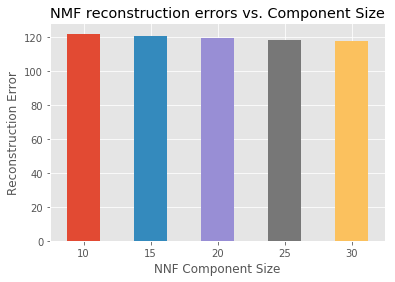

In [5]:
nmf_error = pd.read_csv('nmf_rec_errors.csv', index_col=0, squeeze=True)
ax = nmf_error.plot(kind='bar', title='NMF reconstruction errors vs. Component Size', rot=0)
_ = ax.set(xlabel='NNF Component Size', ylabel='Reconstruction Error')

Based on this, I chose the number of components as **20**. 

## Optimal Cluster Size

To select the optimal cluster size for KMeans, I plotted the inertia (Sum of squared distances of each sample from the its cluster centroid) vs. the number of clusters ranging from 2 to 30 on the 16000 sample dataset.

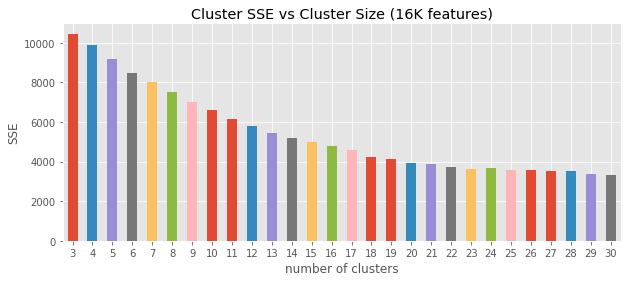

In [6]:
sse = pd.read_csv('kmeans_sse.csv', index_col=0, squeeze=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax = sse.plot(kind='bar', title='Cluster SSE vs Cluster Size (16K features)', ax=ax, rot=0)
_ = ax.set(xlabel='number of clusters', ylabel='SSE')

This is commonly known as the "Elbow Plot" and the optimal cluster size is the point where the SSE curve starts to flatten out. In this case, I chose the optimal cluster size as **20**.

## Cluster Assignments and Comparison with Level

Next I executed the feature construction, dimension reduction and clustering steps for the full dataset. The figure shows the value counts per cluster and value counts per level.

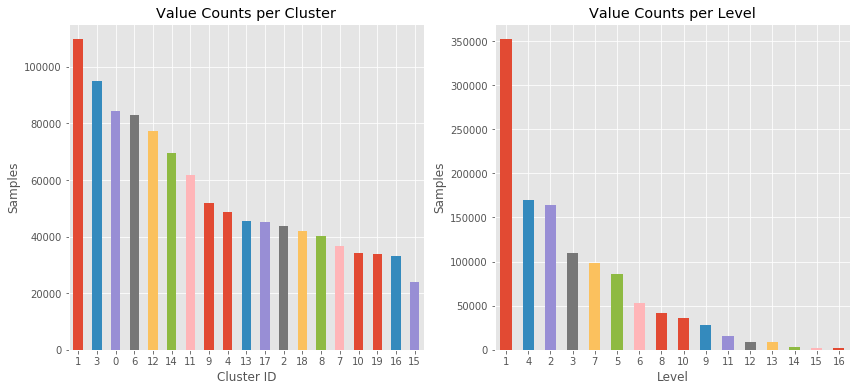

In [7]:
cluster_counts = pd.read_csv('label_counts_all.csv', index_col=0, squeeze=True)
level_counts = raw_input.level.value_counts()

_, ax = plt.subplots(1, 2, figsize=(14, 6))

ax_0 = cluster_counts.plot(ax=ax[0], kind='bar', title='Value Counts per Cluster', rot=0)
_ = ax_0.set(xlabel='Cluster ID', ylabel='Samples')

ax_1 = level_counts.plot(ax=ax[1], kind='bar', title='Value Counts per Level', rot=0)
_ = ax_1.set(xlabel='Level', ylabel='Samples')

Visually, this approach to clustering results aren't similar to the `level`s. To get a more quantifiable for measure between the two, I calculated the Adjusted Rand Index (which ranges from 0 to 1). The Adjusted Rand Index between this cluster assignment and the `level` attribute is **0.089**, indicating that they are quite dissimilar.

The figure below shows cross-tabulation of Cluster IDs vs. the `level` attribute:

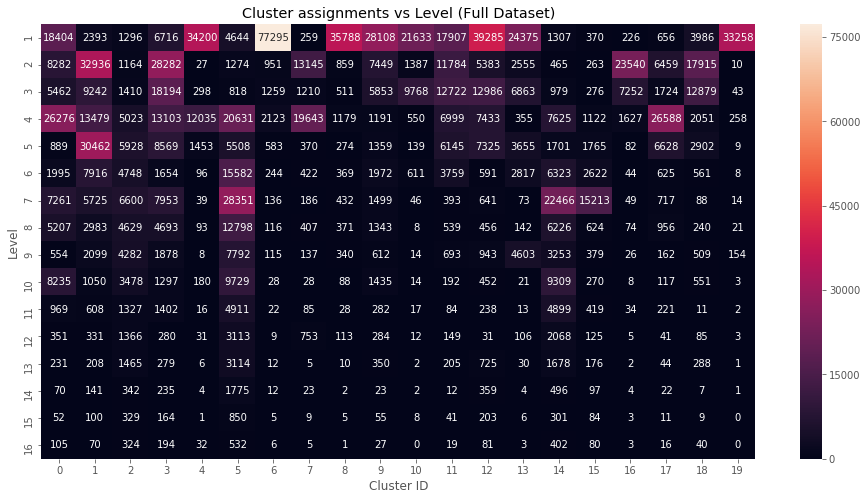

In [8]:
ct_full = pd.read_csv('cluster_assignment_vs_labels_all.csv', index_col=0)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax = sns.heatmap(ct_full, annot=True, fmt='d', ax=ax)
_ = ax.set(title='Cluster assignments vs Level (Full Dataset)')
_ = ax.set(xlabel='Cluster ID', ylabel='Level')

The crosstab plot shows that the lower (1-4) levels are spread over most of the clusters. One possible way to interpret this result is that the NMF is capturing common themes between the mutually exclusive sets of topics assigned to different levels. Another possibility, given that the NNF reconstruction error does not change much for component sizes between 10-30, is that the transformed feature matrix isn't an appropriate approximation of the full term-document matrix. Using a much larger component size could produce a better approximation.